In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from utils.functions import clean_uber_data
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [18]:
csv_path = "../data/uber.csv"
df = pd.read_csv(csv_path)

In [19]:
# Define bounds for New York City
LAT_MAX = 40.9
LAT_MIN = 40.6
LONG_MAX = -73.6
LONG_MIN = -74.2
assert (LAT_MAX >= -90 and LAT_MAX <= 90) and (LAT_MIN >= -90 and LAT_MIN <= 90) and (LONG_MAX >= -90 and LONG_MAX <= 90) and (LONG_MIN >= -90 and LONG_MIN <= 90)
assert LAT_MIN < LAT_MAX and LONG_MIN < LONG_MAX

# Assuming df is your original DataFrame
df_cleaned, dropped_rows = clean_uber_data(df, LONG_MIN, LONG_MAX, LAT_MIN, LAT_MAX)

In [32]:
# Assuming your dataset is in a pandas DataFrame called df
# Relevant features for the model
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
            'dropoff_latitude', 'passenger_count', 'pickup_hour', 'distance_miles']
target = 'fare_amount'

# Split the data into train and test sets
X = df_cleaned[features].values
y = df_cleaned[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for output
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [33]:
# Define the neural network model
class FarePredictionModel(nn.Module):
    def __init__(self):
        super(FarePredictionModel, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)  # Input layer
        self.fc2 = nn.Linear(128, 64)  # Hidden layer 1
        self.fc3 = nn.Linear(64, 32)   # Hidden layer 2
        self.fc4 = nn.Linear(32, 1)    # Output layer
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [34]:
# Load the model
model = FarePredictionModel()

# Load the saved weights
model_path = '../models/fare_estimator.pth'
model.load_state_dict(torch.load(model_path))

print(f"Model loaded from {model_path}")

Model loaded from ../models/fare_estimator.pth


In [35]:
# Ensure model is in evaluation mode
model.eval()

# Perform inference on the test data
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Predicted fares

# Convert the predicted fares (test_outputs) and actual fares (y_test_tensor) to NumPy arrays
predicted_fares = test_outputs.numpy().flatten()  # Convert predictions to NumPy and flatten to 1D array
actual_fares = y_test_tensor.numpy().flatten()    # Convert actual values to NumPy and flatten to 1D array

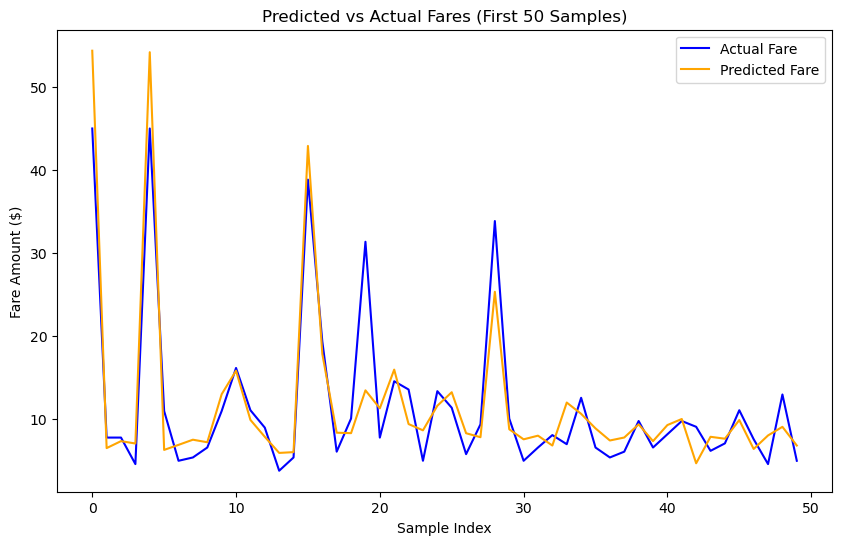

In [39]:
import matplotlib.pyplot as plt
import torch

# Assuming your predicted fares and actual fares are in tensors `test_outputs` and `y_test_tensor`
# Convert these tensors to NumPy arrays for easy plotting
predicted_fares = test_outputs.numpy().flatten()  # Flatten to 1D array
actual_fares = y_test_tensor.numpy().flatten()    # Flatten to 1D array

# Limit to the first 50 samples
predicted_fares_50 = predicted_fares[:50]
actual_fares_50 = actual_fares[:50]

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot actual fares as a blue line (only 50 samples)
plt.plot(actual_fares_50, color='blue', label='Actual Fare')

# Plot predicted fares as an orange line (only 50 samples)
plt.plot(predicted_fares_50, color='orange', label='Predicted Fare')

# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Fare Amount ($)')
plt.title('Predicted vs Actual Fares (First 50 Samples)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


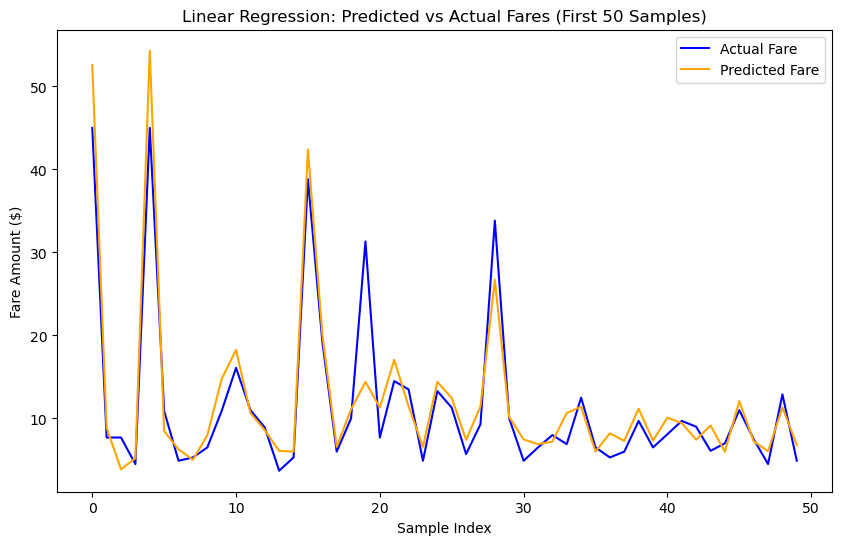

In [40]:
# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_model.predict(X_test)

# Limit to the first 50 samples
predicted_fares_50 = y_pred[:50]
actual_fares_50 = y_test[:50]

# Create a figure and axis for plotting
plt.figure(figsize=(10, 6))

# Plot actual fares as a blue line (only 50 samples)
plt.plot(actual_fares_50, color='blue', label='Actual Fare')

# Plot predicted fares as an orange line (only 50 samples)
plt.plot(predicted_fares_50, color='orange', label='Predicted Fare')

# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Fare Amount ($)')
plt.title('Linear Regression: Predicted vs Actual Fares (First 50 Samples)')

# Add a legend
plt.legend()

# Show the plot
plt.show()